<a href="https://colab.research.google.com/github/shonyeajin/KCBD/blob/main/%EC%BA%90%EC%B0%BD%EB%B0%B0%EB%94%A5_%ED%9A%8C%EA%B7%80%EB%AC%B8%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets),(test_data, test_targets)= boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [4]:
#정규화
mean=train_data.mean(axis=0)
train_data-=mean
std=train_data.std(axis=0)
train_data/=std

test_data-=mean
test_data/=std

In [6]:
train_data.shape[1]

13

In [10]:
#모델 구성
from keras import models
from keras import layers
import tensorflow as tf

def build_model():
  model=models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop',loss='mse',metrics=[tf.keras.metrics.MeanAbsoluteError()]) # mse: 평균제곱 오차, mae:평균절대 오차
  return model

K-fold cross-validation (k겹 교차 검증)

In [8]:
import numpy as np

k=4 #fold size
num_val_samples=len(train_data)//k
num_epochs=100
all_scores=[]
for i in range(k):
  print('처리중인 폴드 #',i)
  val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
  val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]

  partial_train_data=np.concatenate( # 검증 폴드로 쓰일 부분 제외 다른 폴드 다 합쳐서 train용으로 쓰기
      [train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]],
      axis=0
  )
  partial_train_targets=np.concatenate(
      [train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]],
      axis=0
  )

  model= build_model()
  model.fit(partial_train_data, partial_train_targets,epochs=num_epochs,batch_size=1, verbose=0)
  val_mse, val_mae= model.evaluate(val_data, val_targets,verbose=0)
  all_scores.append(val_mae)


처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


각 폴드에서 검증 점수를 로그에 저장하기

In [13]:
num_epochs=500
all_mae_histories=[]
for i in range(k):
  print('처리중인 폴드 #',i)
  val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
  val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]

  partial_train_data=np.concatenate( # 검증 폴드로 쓰일 부분 제외 다른 폴드 다 합쳐서 train용으로 쓰기
      [train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]],
      axis=0
  )
  partial_train_targets=np.concatenate(
      [train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]],
      axis=0
  )
  model= build_model()
  history=model.fit(partial_train_data, partial_train_targets,epochs=num_epochs,batch_size=1, verbose=0)
  mae_history=history.history['mean_absolute_error']
  all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [16]:
average_mae_history=[np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

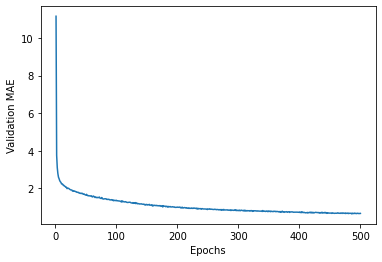

In [19]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

앞의 10개 빼고 지수이동평균(exponential moving average)로 대체

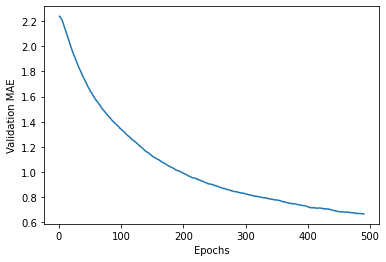

In [21]:
def smooth_curve(points, factor=0.9):
  smoothed_point=[]
  for point in points:
    if smoothed_point:
      previous=smoothed_point[-1]
      smoothed_point.append(previous*factor+point*(1-factor))
    else:
      smoothed_point.append(point)
  return smoothed_point

smooth_mae_history=smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


val로 해야하는데 train의 데이터로 해서 망했음-> history 에서 key 값 제대로 추출해서 다시 해보기

In [23]:
model=build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=1, verbose=0)
test_mse_score, test_mae_score=model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 12.2642 - mean_absolute_error: 2.3129
